In [395]:
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
scenario = "testing"

In [396]:
sns.set_theme(style="whitegrid")
#path_to_results = os.path.join(os.path.dirname(os.path.dirname(os.getcwd()) ), "amiris_workflow", "2050example")
path_to_results = os.path.join(os.path.dirname(os.path.dirname(os.getcwd()) ), "amiris_workflow" )
path_to_structure = os.path.join(path_to_results, "amiris_data_structure.xlsx")

path_to_h2 = os.path.join(path_to_results, "amiris-config", "data","LS_hydrogen.csv")
#path_to_industrial = os.path.join(path_to_results, "amiris-config", "data","LS_industrial.csv")
path_to_output = os.path.join(path_to_results, "output","amiris_results.csv" )
path_to_storage_levels = os.path.join(path_to_results, "output","final_storage_levels.csv" )
path_to_generation = os.path.join(path_to_results, "output","hourly_generation_per_group.csv" )
# path_to_load = os.path.join(path_to_results, "amiris-config", "data","load.csv")

path_to_electricity_prices = os.path.join(path_to_results, "output","raw","EnergyExchangeMulti.csv" )

path_to_plots = os.path.join(os.getcwd(),  "Scenarios", "AMIRIS_Results", scenario )
if not os.path.exists(path_to_plots):
    os.makedirs(path_to_plots)
#-----------------------------------------------------------------------------
elec_prices_data = pd.read_csv(path_to_electricity_prices, sep=";")  
generation_data =  pd.read_csv(path_to_generation, index_col="Unnamed: 0")
# load_data = pd.read_csv(path_to_load, sep=";", header=None) 


h2_high_data = pd.read_csv(path_to_h2, sep=";", header=None) 
#industrial_data = pd.read_csv(path_to_industrial, sep=";", header=None) 
results_data = pd.read_csv(path_to_output) 
storage_levels_data = pd.read_csv(path_to_storage_levels) 
storages_data = pd.read_excel(path_to_structure, sheet_name='storages', index_col=0)
conventionals_data = pd.read_excel(path_to_structure, sheet_name='conventionals', index_col=0)
renewables_data = pd.read_excel(path_to_structure, sheet_name='renewables', index_col=0)
electrolysers_data = pd.read_excel(path_to_structure, sheet_name='electrolysers', index_col=0)
biogas_data = pd.read_excel(path_to_structure, sheet_name='biogas', index_col=0)
load_shedders_data = pd.read_excel(path_to_structure, sheet_name='load_shedding')

# Why is the electrolysis_hydrogen_generation given in the load generation? I think that value is not needed. 


In [397]:
loads = pd.DataFrame()
for rownum,(indx,i)  in enumerate(load_shedders_data["TimeSeries"].iteritems()): 
    print(i)
    if i != "amiris-config/data/LS_hydrogen.csv":
        path_to_load = os.path.join(path_to_results, i)
        load = pd.read_csv(path_to_load, sep=";", header=None)
        loads[rownum] = load[1]
    

amiris-config/data/future_load.csv
amiris-config/data/future_LS_high.csv
amiris-config/data/LS_hydrogen.csv
amiris-config/data/future_LS_low.csv
amiris-config/data/future_LS_mid.csv


In [398]:
load_data = loads.sum(axis=1)

In [399]:
fuelprices = pd.read_excel(path_to_structure, sheet_name='scenario_data_emlab', index_col=0)
industrial_heat_price = fuelprices.loc[1,"HYDROGEN"]
fuelprices

,AgentType,CO2,OTHER,HARD_COAL,OIL,HYDROGEN,LIGNITE,NATURAL_GAS,NUCLEAR,WASTE,BIOMASS
0,CarbonMarket,168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FuelsMarket,NaN,45.1,6.73,79.69,48.579253,6.48,14.65,1.69,7.5,35.0


In [400]:
print("Conventionals " + str(conventionals_data["InstalledPowerInMW"].sum()/1000))
print("Renewables " + str(renewables_data["InstalledPowerInMW"].sum()/1000))
print("electrolysers " + str(electrolysers_data["PeakConsumptionInMW"].sum()/1000))
print("biogas " + str(biogas_data["InstalledPowerInMW"].sum()/1000))

Conventionals 17.163943
Renewables 111.35
electrolysers 11.775
biogas 0.0


In [401]:
electrolyser_capacity = h2_high_data[1][0] 
input_hydrogen_demand = h2_high_data[1].sum()
print(input_hydrogen_demand)

359781959.00000006


In [402]:
h2_high_data[1]

0       41070.999886
1       41070.999886
2       41070.999886
3       41070.999886
4       41070.999886
            ...     
8755    41070.999886
8756    41070.999886
8757    41070.999886
8758    41070.999886
8759    41070.999886
Name: 1, Length: 8760, dtype: float64

In [403]:
windon = renewables_data[renewables_data["Set"] =="WindOn"]
print(windon["InstalledPowerInMW"].sum())
windoff = renewables_data[renewables_data["Set"] =="WindOff"]
print(windoff["InstalledPowerInMW"].sum())
PV = renewables_data[renewables_data["Set"] =="OtherPV"]
print(PV["InstalledPowerInMW"].sum())
ROR = renewables_data[renewables_data["Set"] =="RunOfRiver"]
print(ROR["InstalledPowerInMW"].sum())

12000
37000
62350
0


In [404]:
max_output_onshore = 2978 # capacity factor times hours = FLH
max_output_offshore = 4730
max_output_pv = 1059
max_output_ror = 2102
theoretical_max_offshore = max_output_offshore*windoff["InstalledPowerInMW"].sum() # MWH
theoretical_max_onshore = max_output_onshore*windon["InstalledPowerInMW"].sum()
theoretical_max_pv = max_output_pv*PV["InstalledPowerInMW"].sum()
theoretical_max_ror = max_output_ror*ROR["InstalledPowerInMW"].sum()
max_RES = theoretical_max_offshore + theoretical_max_onshore + theoretical_max_pv  + theoretical_max_ror

In [405]:
windon_join = pd.merge(windon, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
print(windon_join["PRODUCTION_IN_MWH"].sum()/1000000)
windoff_join = pd.merge(windoff, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
print(windoff_join["PRODUCTION_IN_MWH"].sum()/1000000)
PV_join = pd.merge(PV, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
print(PV_join["PRODUCTION_IN_MWH"].sum()/1000000)
ROR_join = pd.merge(ROR, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
print(ROR_join["PRODUCTION_IN_MWH"].sum()/1000000)

47.90567035333329
168.32241375808985
91.67488434085989
0.0


In [406]:
conventionals_join = pd.merge(conventionals_data, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
storages_results = pd.merge(storages_data, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
electrolysers_results = pd.merge(electrolysers_data, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
renewables_results = pd.merge(renewables_data, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
renewables_results.head()

,identifier,InstalledPowerInMW,OpexVarInEURperMWH,Set,SupportInstrument,FIT,Premium,Lcoe,ENERGY_SHEDDED_IN_MWH,CONSUMPTION_IN_MWH,VARIABLE_COSTS_IN_EURO,REVENUES_IN_EURO,PRODUCTION_IN_MWH,CONTRIBUTION_MARGIN_IN_EURO
0,20490300048,3000,0.00,OtherPV,NONE,-,-,-,NaN,NaN,0.000000e+00,1.261196e+08,4.410981e+06,1.261196e+08
1,20480200026,2400,1.35,WindOn,NONE,-,-,-,NaN,NaN,1.293453e+07,3.569364e+08,9.581134e+06,3.440019e+08
2,20480300047,3850,0.00,OtherPV,NONE,-,-,-,NaN,NaN,0.000000e+00,1.618535e+08,5.660759e+06,1.618535e+08
3,20480100060,3000,2.70,WindOff,NONE,-,-,-,NaN,NaN,3.684896e+07,4.967067e+08,1.364776e+07,4.598577e+08
4,20470300046,3500,0.00,OtherPV,NONE,-,-,-,NaN,NaN,0.000000e+00,1.471395e+08,5.146144e+06,1.471395e+08


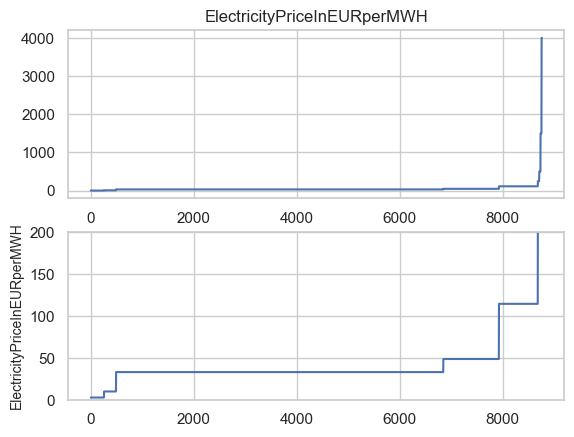

In [407]:
sorted_elec_prices = elec_prices_data["ElectricityPriceInEURperMWH"].copy()
fig, axes= plt.subplots(nrows=2, ncols=1)
sorted_elec_prices.sort_values(ignore_index=True, inplace=True)
axs1 = sorted_elec_prices.plot(ax=axes[0])
plt.ylim([0, 200])
axs2 = sorted_elec_prices.plot(ax=axes[1])
plt.ylabel('ElectricityPriceInEURperMWH', fontsize='small')
axes[0].set_title('ElectricityPriceInEURperMWH')
fig.savefig(path_to_plots + '/' + 'elec_prices.png', bbox_inches='tight', dpi=300)


In [408]:
load_generation = pd.concat([generation_data, 
                      load_data],   axis=1)
# load_generation.drop(0, axis=1, inplace=True) # dropping timeseries
load_generation.rename(columns={0: "load" }, inplace=True)
# load_generation.sort_values(by=1, inplace=True) # sorting by increasing load
# load_generation.reset_index(inplace=True )
#load_generation.drop("index", axis=1, inplace=True)
load_generation.drop("electrolysis_hydrogen_generation", axis=1, inplace=True)
load_generation.head()

,res,conventionals,storages_discharging,storages_charging,storages_aggregated_level,load_shedding,electrolysis_power_consumption,load
0,25819.824686,5663.943,0,0,0,40428.219873,11775.0,19065.987673
1,26115.972896,5663.943,0,0,0,39998.060176,11775.0,18931.976186
2,29219.055920,5663.943,0,0,0,36578.023672,11775.0,18615.022706
3,32133.444725,5663.943,0,0,0,33595.895859,11775.0,18547.283698
4,33943.346864,5663.943,0,0,0,32231.746154,11775.0,18993.036132


In [409]:
load_generation["storages_charging"] = load_generation["storages_charging"]*-1
load_generation["electrolysis_power_consumption"] = load_generation["electrolysis_power_consumption"]*-1
load_generation.drop("storages_aggregated_level", axis=1, inplace=True)

In [410]:
RES_use = round((load_generation["res"].sum()/max_RES)*100,2)

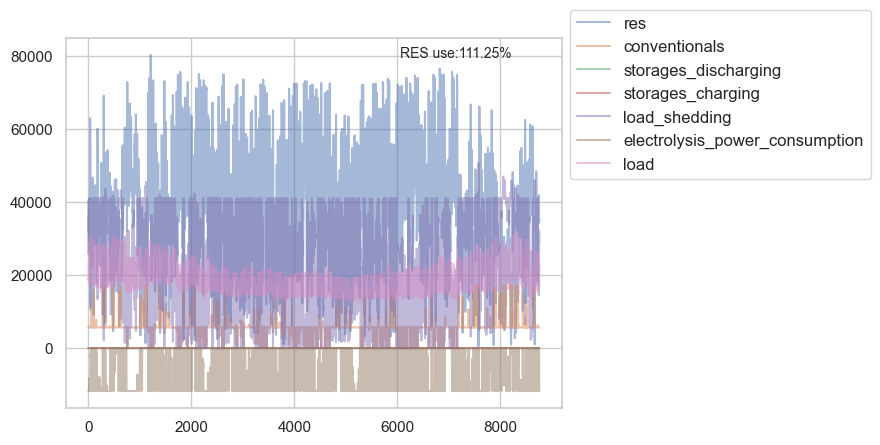

In [411]:
axs1= load_generation.plot(alpha=0.5)
plt.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1, 1.1))
axs1.annotate("RES use:" + str(RES_use ) + "%",
               xy=(0.8, 0.8), xycoords='figure fraction',
               horizontalalignment='right', verticalalignment='bottom',
               fontsize='small')
fig1 = axs1.get_figure()
fig1.savefig(path_to_plots + '/' + 'testing.png', bbox_inches='tight', dpi=300)

,res,conventionals,storages_discharging,storages_charging,load_shedding,electrolysis_power_consumption,load
0,25819.824686,5663.943,0,0,40428.219873,11775.0,19065.987673
1,26115.972896,5663.943,0,0,39998.060176,11775.0,18931.976186
2,29219.055920,5663.943,0,0,36578.023672,11775.0,18615.022706
3,32133.444725,5663.943,0,0,33595.895859,11775.0,18547.283698
4,33943.346864,5663.943,0,0,32231.746154,11775.0,18993.036132


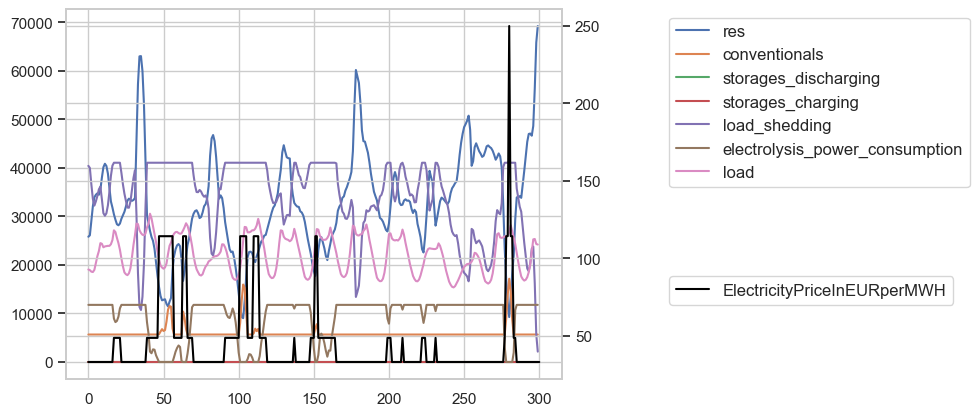

In [412]:
ElectricityPriceInEURperMWH = elec_prices_data["ElectricityPriceInEURperMWH" ]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
load_generation["electrolysis_power_consumption"] = load_generation["electrolysis_power_consumption"]*-1
load_generation.iloc[0:300,0:7].plot( ax=ax1)

ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2,    1))
ax2.plot(ElectricityPriceInEURperMWH.loc[0:300] , color = "black")
#ax2.set_ylim(-1000, 4100)
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.3))
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'timeseries.png', bbox_inches='tight', dpi=300)

load_generation.head()

In [413]:
fuel_colors = {
    'Industrial heat': "black",
    'H2 turbine': "darkred",
    "PV": "gold",
    'Nuclear': "mediumorchid",
    'Offshore': "navy",
    'Onshore': "blue",
    'notfound': "purple",
    'Electrolyzer': "gray",
    "LowLS": "lemonchiffon",
    'HighLS': "darkorange",
    'MedLS': "orange",
    "VOLL": "lime",
    "Wind and Solar": "green",
    "Nuclear and H2 turbines" : "darkred", 
    "Static Load": "purple"
}

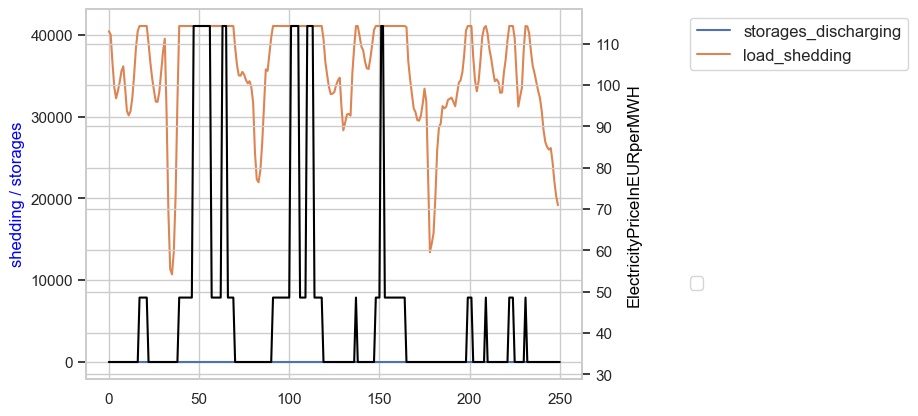

In [414]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
load_generation.iloc[0:250,[2,4]].plot( ax=ax1)
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2,    1))
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.3))
ax2.plot(ElectricityPriceInEURperMWH.loc[0:250] , color = "black")
ax1.set_ylabel('shedding / storages',  color = "blue")
ax2.set_ylabel('ElectricityPriceInEURperMWH', color = "black")
fig.savefig(path_to_plots + '/' + 'storages_loadshedding.png', bbox_inches='tight', dpi=300)

In [415]:
# plt.stackplot( load_generation.index, load_generation.res, load_generation.conventionals, load_generation.load_shedding, load_generation.storages_discharging,
#               load_generation.storages_discharging,  labels=['RES', 'conventional', "load shedding", "dish", "charg"]  )


In [416]:
storages = None
if storages != None:
    path_to_storages_raw = os.path.join(path_to_results, "output","raw","StorageTrader.csv")
    storages_raw = pd.read_csv(path_to_storages_raw, sep=";") 
    storages_results["InstalledPowerInMW"].sum()
    #storage_levels_data["value"][1:].plot.scatter() # 
    storage_levels_data.reset_index().plot.scatter(x = 'index', y = 'value')
    production = storages_results['PRODUCTION_IN_MWH'].sum()
    discharging = generation_data["storages_discharging"].sum()
    charging = generation_data["storages_charging"].sum()

    print("storages GW: " + str(storages_data["InstalledPowerInMW"].sum()/1000))
    
    total_battery_use = load_generation["storages_discharging"].sum()
    print("batteries use GWh: " + str(total_battery_use/1000))
    
    batteries_FLH = (total_battery_use/storages_data["InstalledPowerInMW"].sum())
    print("batteries_FLH: " + str(batteries_FLH)) 
    print("production/discharging "+ str(production/discharging) )
    discharging/charging

In [417]:
#this only work when there is one battery!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# storages_bids_discharge = storages_raw["OfferedDischargePriceInEURperMWH"].dropna()
# storages_bids_discharge.reset_index(drop=True, inplace = True)
# storages_bids_charge = storages_raw["OfferedChargePriceInEURperMWH"].dropna()
# storages_bids_charge.reset_index(drop=True, inplace = True)
# storages_bids_charge.sort_values(ignore_index=True).plot()

# AwardedDischargePowerInMWH = storages_raw["AwardedDischargePowerInMWH"].dropna()
# AwardedDischargePowerInMWH.reset_index(drop=True, inplace = True)
# plt.scatter(x = ElectricityPriceInEURperMWH , y= AwardedDischargePowerInMWH )
# plt.legend()
# plt.xlabel("ElectricityPriceInEURperMWH")
# plt.ylabel("AwardedDischargePowerInMWH")
# plt.savefig(path_to_plots + '/' + 'DischargePowervsprices.png', bbox_inches='tight', dpi=300)
# plt.show()
# plt.close()
# x = storages_bids_discharge.values.reshape(-1,1)
# y = storages_bids_charge.values.reshape(-1,1)
# regr = LinearRegression()
# regr.fit(x, y)
# fig = plt.scatter(x, y,  color='black')
# plt.plot(x, regr.predict(x), color='blue', linewidth=3)
# plt.xlabel("ElectricityPriceInEURperMWH")
# plt.ylabel("OfferedDischargePriceInEURperMWH")
# plt.legend()
# plt.show()
# print("Coefficients: \n", regr.coef_)
# fig, ax1 = plt.subplots()
# storages_bids_discharge.loc[8500:8760].plot(color = "blue")
# ElectricityPriceInEURperMWH.loc[8500:8760].plot( color = "black")
# ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 1))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0

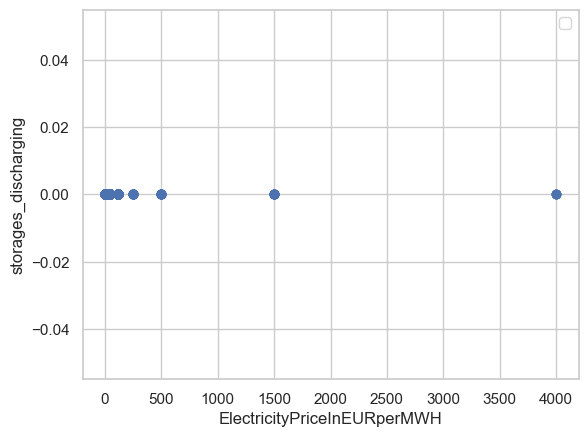

In [418]:
plt.scatter(x = ElectricityPriceInEURperMWH , y= load_generation["storages_discharging"] )
plt.legend()
plt.xlabel("ElectricityPriceInEURperMWH")
plt.ylabel("storages_discharging")
plt.savefig(path_to_plots + '/' + 'BatteriesProductionvsPricesTimeseries.png', bbox_inches='tight', dpi=300)
load_generation["storages_discharging"].sum()

storages_charging       0.0
storages_discharging    0.0


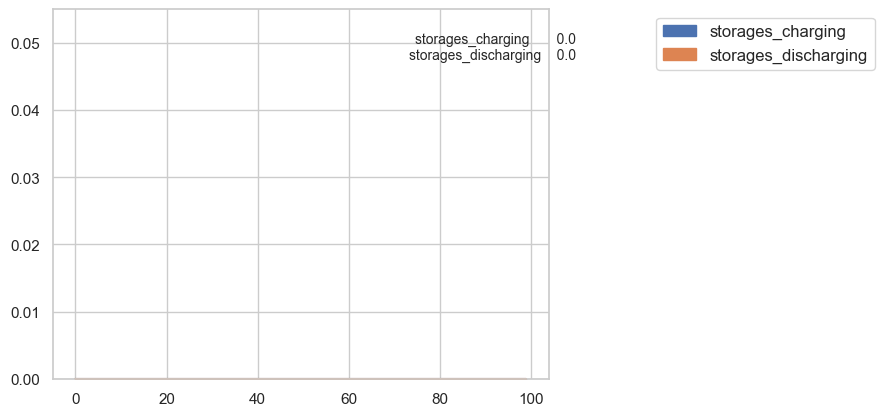

In [419]:
storages = load_generation[["storages_charging", "storages_discharging"]].copy()
sum_storages = storages.sum().divide(1000).to_string()
print(sum_storages)
ax1 = storages.iloc[0:100,:].plot.area()
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 1))
ax1.annotate(sum_storages,
               xy=(0.9, 0.8), xycoords='figure fraction',
               horizontalalignment='right', verticalalignment='top',
               fontsize='small')
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'storages_timeseries.png', bbox_inches='tight', dpi=300)

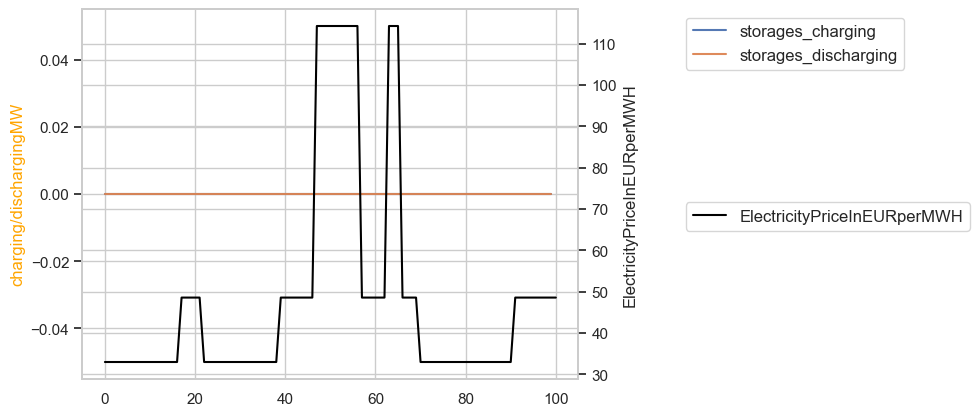

In [420]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
storages.iloc[0:100,:].plot( ax=ax1, alpha=0.95)
#load_generation.iloc[8000:8120,4].plot( ax=ax1, alpha=0.95)
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 1))
ax2.plot(ElectricityPriceInEURperMWH.loc[0:100] , color = "black")
ax1.set_ylabel('charging/dischargingMW',  color = "orange")
ax2.set_ylabel('ElectricityPriceInEURperMWH')
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.5))
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'storages_timeseries_short.png', bbox_inches='tight', dpi=300)

In [421]:
industrialConsumptioninMWh  = load_generation["electrolysis_power_consumption"]

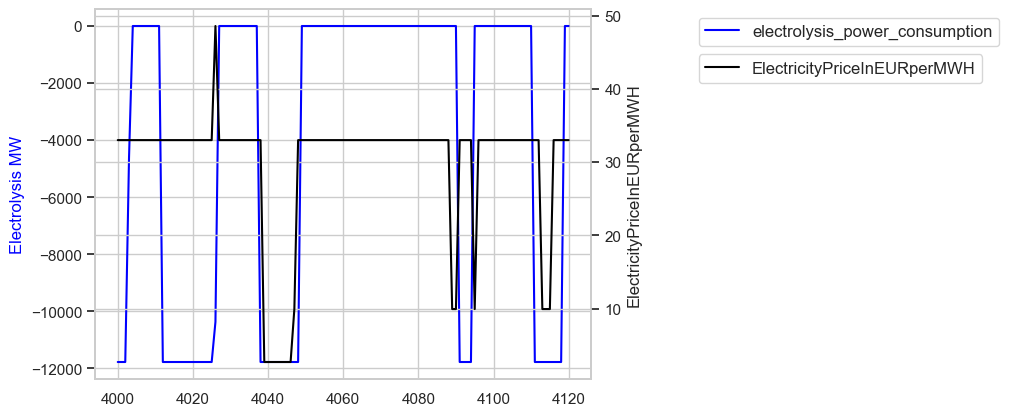

In [422]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
industrialConsumptioninMWh = industrialConsumptioninMWh*-1
industrialConsumptioninMWh.loc[4000:4120].plot( ax=ax1, color = "blue")
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 1))
ax2.plot(ElectricityPriceInEURperMWH.loc[4000:4120] , color = "black")
ax1.set_ylabel('Electrolysis MW', color = "blue")
ax2.set_ylabel('ElectricityPriceInEURperMWH')
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.9))
plt.savefig(path_to_plots + '/' + 'H2vsPricesTimeseries.png', bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>

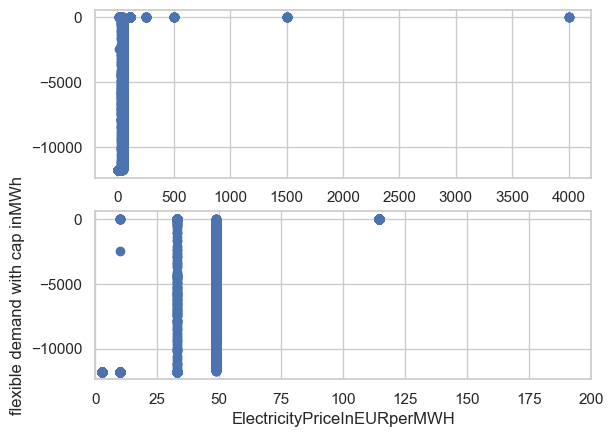

In [423]:
electricityPrice= ElectricityPriceInEURperMWH.values.reshape(-1,1)
industrialPower = industrialConsumptioninMWh.values.reshape(-1,1)
#fig = plt.scatter(electricityPrice, electrolysisPower)
f = plt.figure()  
fig, axes= plt.subplots(nrows=2, ncols=1)
axes[0].scatter(electricityPrice, industrialPower)

axes[1].scatter(electricityPrice, industrialPower)
plt.xlim([0, 200])
plt.xlabel("ElectricityPriceInEURperMWH")
plt.ylabel("flexible demand with cap inMWh")
plt.savefig(path_to_plots + '/' + 'H2vsPrices.png', bbox_inches='tight', dpi=300)

In [424]:
h2prices = pd.DataFrame(list(zip(ElectricityPriceInEURperMWH, industrialConsumptioninMWh)),
              columns =['electricityPrice', 'flexiblePowerCap'])
h2prices.head()

,electricityPrice,flexiblePowerCap
0,33.0,-11775.0
1,33.0,-11775.0
2,33.0,-11775.0
3,33.0,-11775.0
4,33.0,-11775.0


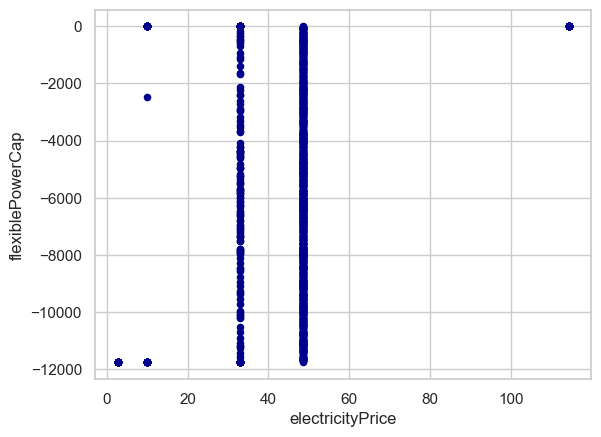

In [425]:
h2prices_filtered = h2prices[h2prices["electricityPrice"] < 200]
ax1 = h2prices_filtered.plot.scatter(x='electricityPrice',
                       y='flexiblePowerCap',
                       c='DarkBlue')
plt.savefig(path_to_plots + '/' + 'flexiblePowerCapvsPricesZoom.png', bbox_inches='tight', dpi=300)
# merged_df.head()


In [426]:
hydrogen_VOLL   = load_shedders_data.loc[load_shedders_data['TimeSeries'] == "amiris-config/data/LS_hydrogen_high.csv", 'VOLL'].sum()
low_VOLL   = load_shedders_data.loc[load_shedders_data['TimeSeries'] == "amiris-config/data/LS_low.csv", 'VOLL'].sum()
mid_VOLL   = load_shedders_data.loc[load_shedders_data['TimeSeries'] == "amiris-config/data/LS_mid.csv", 'VOLL'].sum()
high_VOLL   = load_shedders_data.loc[load_shedders_data['TimeSeries'] == "amiris-config/data/LS_high.csv", 'VOLL'].sum()
load_shedders_data.sort_values(by=['VOLL'], ascending=False, inplace=True)
load_shedders_data.reset_index(inplace=True)

In [427]:

for i, load_shedder in load_shedders_data.iterrows() :
    print(load_shedder["VOLL"])

4000
1500
500
250
33


In [428]:
hydrogen_load = 41071
maximumLS = pd.DataFrame()
maximumLS['hydrogen'] = [hydrogen_load]*8760
maximumLS['LS_low'] = load_data[1]*0.05
# load is 80% so 5% corresponds to 6.25%
maximumLS['LS_mid'] = load_data[1]*0.05
maximumLS['LS_high'] = load_data[1]*0.10
maximumLS['base'] = load_data[1]*0.8
maximumLS.head()

,hydrogen,LS_low,LS_mid,LS_high,base
0,41071,946.598809,946.598809,1893.197619,15145.580949
1,41071,946.598809,946.598809,1893.197619,15145.580949
2,41071,946.598809,946.598809,1893.197619,15145.580949
3,41071,946.598809,946.598809,1893.197619,15145.580949
4,41071,946.598809,946.598809,1893.197619,15145.580949


In [429]:
load_shedded_per_group = pd.DataFrame()
nextcolumns =  maximumLS.columns
last = []
for num, column in enumerate(maximumLS.columns):
    if num == 0 :
        load_shedded_per_group[column] =  load_generation["load_shedding"] # hydrogen shedding same as load shedding 
    else: # next load shedders are load shedded minus the last load shedders
        load_shedded_per_group[column] =  load_generation["load_shedding"] 
        load_shedded_per_group[column] = load_shedded_per_group[column] - maximumLS[last].sum(axis=1)
    last.append(column)

In [430]:
load_shedded_per_group['load_shedding'] = load_generation["load_shedding"]
load_shedded_per_group['ElectricityPriceInEURperMWH'] = ElectricityPriceInEURperMWH

In [431]:
load_shedders_data['VOLLnext'] = load_shedders_data['VOLL'].shift(-1)
load_shedders_data.at[4, 'VOLLnext'] = -100
dict_LS_VOLL = {33:"hydrogen", 250: "LS_low"  , 500 : "LS_mid" , 1500: "LS_high" , 4000:"base"}

In [432]:
load_shedded = pd.DataFrame(index = load_shedded_per_group.index)
number_load_shedders = len(load_shedded_per_group)
max_price = 4000
for rownum,(indx,VOLL)  in enumerate(load_shedders_data["VOLL"].iteritems()):      

    name = dict_LS_VOLL[VOLL]
    lastVOLL = load_shedders_data.at[rownum,"VOLLnext"]
    print(str(name) + str(lastVOLL ) + " -> " + str(VOLL))
    
    # load shedded 
    load_shedded[str(name)] = load_shedded_per_group.loc[  
        (load_shedded_per_group['ElectricityPriceInEURperMWH'] > lastVOLL ) &
        (load_shedded_per_group['ElectricityPriceInEURperMWH']<= VOLL ) & 
        (load_shedded_per_group['load_shedding'] > 0 ) , str(name)]
 
    rows_where_VOLL_is_higher = ((load_shedded_per_group['ElectricityPriceInEURperMWH'] > VOLL ) &
                (load_shedded_per_group['load_shedding'] > 0 ))

    load_shedded.loc[rows_where_VOLL_is_higher, str(name)] = maximumLS.loc[rows_where_VOLL_is_higher , str(name)] 

    
load_shedded.fillna(0, inplace=True)


base1500.0 -> 4000
LS_high500.0 -> 1500
LS_mid250.0 -> 500
LS_low33.0 -> 250
hydrogen-100.0 -> 33


In [433]:
maximumLS.loc[
        (load_shedded_per_group['ElectricityPriceInEURperMWH'] > VOLL )&
                (load_shedded_per_group['load_shedding'] > 0 ) , str(name)]

17      41071
18      41071
19      41071
20      41071
21      41071
        ...  
8680    41071
8681    41071
8682    41071
8728    41071
8731    41071
Name: hydrogen, Length: 1913, dtype: int64

In [434]:
load_shedded["hydrogen"][10:20]

10    30686.553929
11    30143.273187
12    30655.851985
13    32281.094056
14    35061.991753
15    38352.549567
16    40460.717829
17    41071.000000
18    41071.000000
19    41071.000000
Name: hydrogen, dtype: float64

<AxesSubplot:>

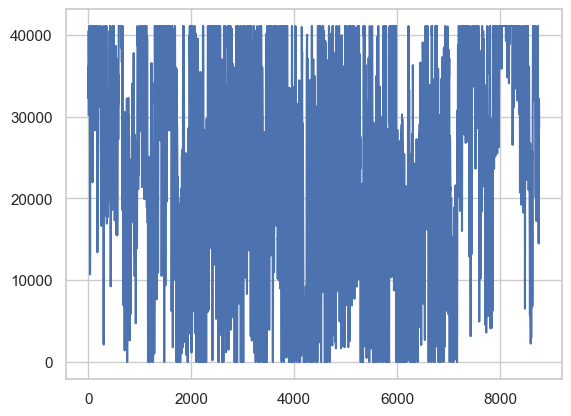

In [435]:
load_shedded["hydrogen"].plot()

<AxesSubplot:>

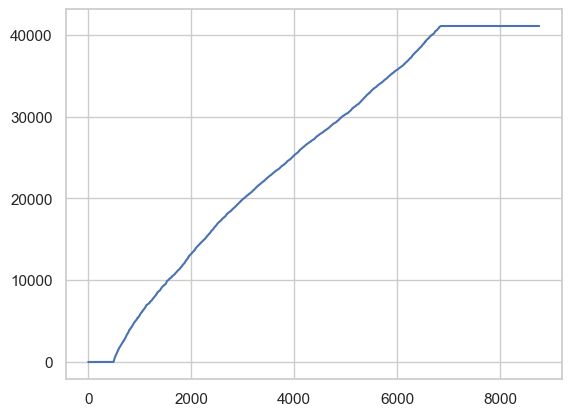

In [436]:
abc = load_shedded["hydrogen"]
abc.sort_values(ignore_index = True).plot()

In [437]:
total_shedded = load_shedded.sum()
total_shedded

base        1.830223e+04
LS_high     4.892156e+04
LS_mid      4.631060e+04
LS_low      6.360180e+04
hydrogen    2.222604e+08
dtype: float64

In [438]:
load_shedders_data

,index,identifier,Type,VOLL,TimeSeries,VOLLnext
0,0,400000000,SHEDDING,4000,amiris-config/data/future_load.csv,1500.0
1,1,150000000,SHEDDING,1500,amiris-config/data/future_LS_high.csv,500.0
2,4,50000000,SHEDDING,500,amiris-config/data/future_LS_mid.csv,250.0
3,3,25000000,SHEDDING,250,amiris-config/data/future_LS_low.csv,33.0
4,2,3300000,SHEDDING,33,amiris-config/data/LS_hydrogen.csv,-100.0


In [440]:
# substracting hydrogen production from load shedding
load_generation["load_shedding"] = load_generation["load_shedding"] - load_shedded['hydrogen']

load_generation["Electrolyzer"] = h2_high_data[1] - load_shedded['hydrogen']
load_generation.head()
hydrogen_ENS = sum(load_shedded['hydrogen'])
hydrogen_ENS

222260350.10659227

In [451]:
# LOLE
LOLE = len(load_generation[(load_generation["load_shedding"]>0) & (ElectricityPriceInEURperMWH == 4000)])


KeyError: 'load_shedding'

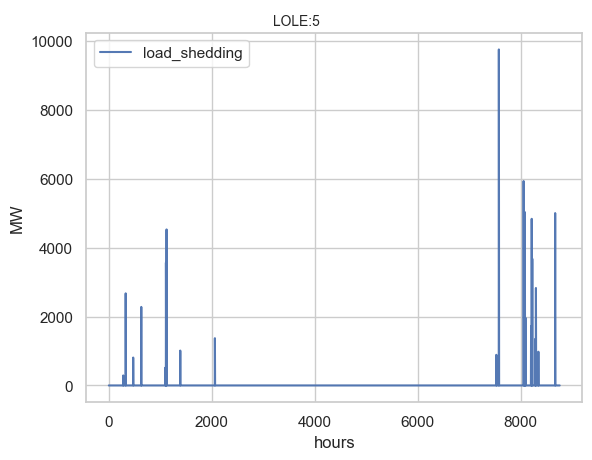

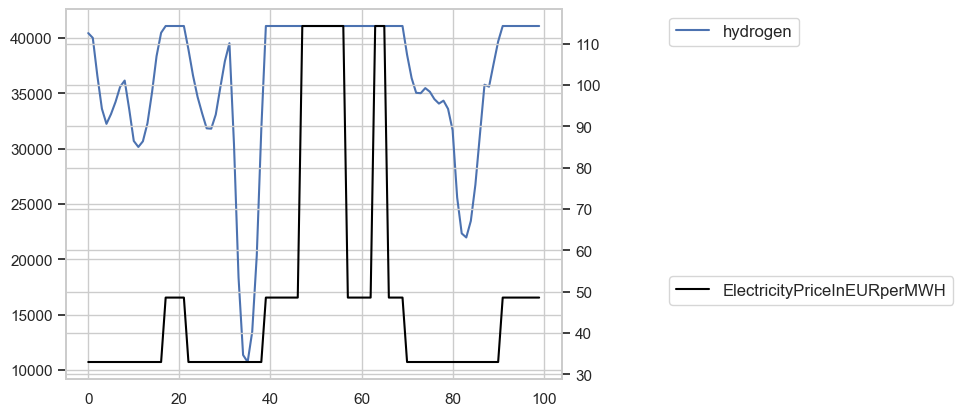

In [442]:
ax1 = load_generation[["load_shedding"]].plot( alpha=0.95)
ax1.annotate("LOLE:" + str(LOLE),
               xy=(0.5, 0.9), xycoords='figure fraction',
               horizontalalignment='right', verticalalignment='bottom',
               fontsize='small')

fig1 = ax1.get_figure()
ax1.set_xlabel("hours")
ax1.set_ylabel("MW")
fig1.savefig(path_to_plots + '/' + 'load_shedding.png', bbox_inches='tight', dpi=300)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
load_shedded['hydrogen'].iloc[0:100].plot(ax=ax1)
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2,    1))
filtered_elec = ElectricityPriceInEURperMWH.loc[(load_generation["load_shedding"]>0) & (ElectricityPriceInEURperMWH <=hydrogen_VOLL)]

ax2.plot(ElectricityPriceInEURperMWH.iloc[0:100] , color = "black")
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.3))
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'load_shedding_timeseries.png', bbox_inches='tight', dpi=300)

In [443]:
#power consumed in MW
flexconsumer_capped= load_generation["electrolysis_power_consumption"].sum()/1000
totalFlexGWh = round(flexconsumer_capped*electrolysers_results.ConversionFactor[0],0)
print("totalFlexGWh " + str(round(totalFlexGWh,0)))

input_flex_demand_GWh = electrolysers_data.HydrogenProductionTargetInMWH.sum()*12/1000
print("input_H2_demand_GWh " + str(round(input_flex_demand_GWh,0)))

produced_flex_demand = round((totalFlexGWh/input_flex_demand_GWh)*100,2)
print("produced_flex_demand % " +str(produced_flex_demand))

totalFlexGWh 52447.0
input_H2_demand_GWh 51576.0
produced_flex_demand % 101.69


In [444]:
produced_hydrogen  =input_hydrogen_demand - hydrogen_ENS
print("hydrogen produced " + str(produced_hydrogen/1000000))
print("hydrogen_ENS " + str(hydrogen_ENS/1000000))
hydrogen_produced_percent = round((produced_hydrogen /input_hydrogen_demand)*100,2)
print("hydrogen produced/reality " + str(hydrogen_produced_percent))

hydrogen produced 137.5216088934078
hydrogen_ENS 222.26035010659226
hydrogen produced/reality 38.22


In [445]:
# # Input = TWh monthly12901502.5
# Input = 12901502.5*12/electrolysers_results.ConversionFactor[0]
# hydrogen_monthly = 15505796
# hydrogen_yearly = hydrogen_monthly*12

# hydrogen_and_industrial_gwh = (input_industrial_demand + hydrogen_monthly*12)/1000 # GWh
# produced_industrial = input_industrial_demand - industrial_ENS

# print("hydrogen_and_industrial GWh  " + str(round(hydrogen_and_industrial_gwh,0)))

# print("industrial produced " + str(produced_industrial))

# hydrogen_capacityfactor = round(produced_hydrogen /input_hydrogen_demand*100,0)
# print(hydrogen_capacityfactor)
# industrial_monthly = 53920638 #input (separate demands)
# industrial_demand = 46531661# acccording to output
# industrial_produced_percent = round(produced_industrial /industrial_demand*100,0)
# print("industrial produced/reality " + str(industrial_produced_percent))

# # if industry produced from electrolyzer
# industrial_produced_percent =hydrogen_producedin_percent


In [446]:
load_generation.drop(columns=["storages_charging","storages_discharging"], inplace=True)

In [447]:
load_generation.rename(columns={"res": "Wind and Solar",
                              "conventionals": "Nuclear and H2 turbines",
                              "load_shedding": "Load Shedding", 
                              "electrolysis_power_consumption": "Industrial heat",
                              "load": "Static Load",                                
                             }, inplace=True)

In [448]:
load_generation.head()

,Wind and Solar,Nuclear and H2 turbines,Load Shedding,Industrial heat,Static Load,Electrolyzer
0,25819.824686,5663.943,0.0,11775.0,19065.987673,642.780012
1,26115.972896,5663.943,0.0,11775.0,18931.976186,1072.939710
2,29219.055920,5663.943,0.0,11775.0,18615.022706,4492.976214
3,32133.444725,5663.943,0.0,11775.0,18547.283698,7475.104027
4,33943.346864,5663.943,0.0,11775.0,18993.036132,8839.253732


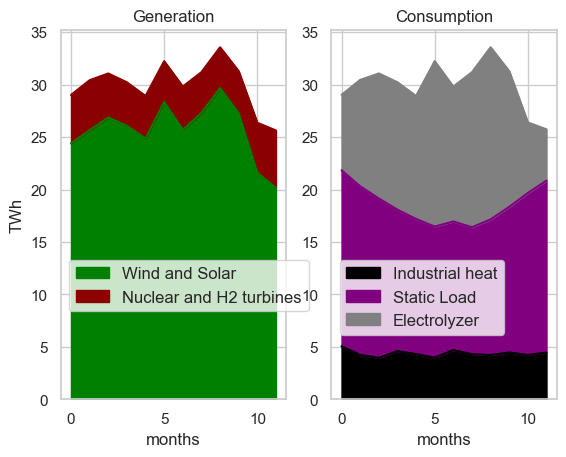

In [449]:
load_generation['group'] = (load_generation.index // 730)
grouped = load_generation.groupby(['group']).sum()
grouped = grouped/1000000

# ax1.annotate("H2 :" + str(hydrogen_produced_percent ) + "%  Industrial " + str(produced_flex_demand) + "%",
#                xy=(0.5, 0.7), xycoords='figure fraction',
#                horizontalalignment='right', verticalalignment='bottom',
#                fontsize='small')

fig3, axs3 = plt.subplots(1,2)
grouped[["Wind and Solar", "Nuclear and H2 turbines"]].plot.area( ax=axs3[0], color = fuel_colors)
grouped[["Industrial heat", "Static Load", "Electrolyzer"]].plot.area( ax=axs3[1], color = fuel_colors)
axs3[0].set_title("Generation")
axs3[1].set_title("Consumption")
axs3[0].set_xlabel("months")
axs3[1].set_xlabel("months")
#axs3[0].set_ylim([0,35])

axs3[0].set_ylabel("TWh")
axs3[0].legend(fontsize='medium', loc='upper left', bbox_to_anchor=(0,0.4))
axs3[1].legend(fontsize='medium', loc='upper left', bbox_to_anchor=(0,0.4))

fig3.savefig(path_to_plots + '/' + 'monthly_production.png', bbox_inches='tight', dpi=300)

In [450]:
path_to_plots

'C:\\toolbox-amiris-emlab\\emlabpy\\plots\\Scenarios\\AMIRIS_Results\\testing'